# Enhancer code analysis

In this notebook we will go over how to obtain cell type characteristic sequence patterns from CREsted models, or any other model, using tfmodisco-lite.

## Obtaining contribution scores per model class and running tfmodisco-lite

Before we can do any analysis, we need to calculate the contribution scores for cell type-specific regions.
From those, we can run tfmodisco-lite.

### Load data and CREsted model

In [1]:
# Optional 
#import os
#os.environ['PATH'] += ':/home/VIB.LOCAL/niklas.kempynck/.conda/envs/crested/bin/'

In [2]:
import anndata
import crested

adata = anndata.read_h5ad("mouse_biccn_data_filtered.h5ad")

genome_file="/home/VIB.LOCAL/niklas.kempynck/nkemp/software/dev_DeepPeak/DeepPeak/data/raw_mm/genome.fa"
datamodule = crested.tl.data.AnnDataModule(
    adata,
    genome_file=genome_file,
)

2024-10-01 10:01:03.016169: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 10:01:03.050541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 10:01:07.122491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# load an existing model
evaluator = crested.tl.Crested(data=datamodule)

evaluator.load_model(
    "deeppeak_benchmarking/dyn_log_loss_TL/checkpoints/01.keras",
    compile=True,
)

2024-10-01 10:01:19.392315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78790 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:55:00.0, compute capability: 9.0


In [4]:
# add predictions for model checkpoint to the adata
evaluator.predict(
    adata, model_name="biccn_model"
)  # adds the predictions to the adata.layers["biccn_model"]

I0000 00:00:1727769681.140101 3714656 service.cc:145] XLA service 0x7fb5440046b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727769681.140133 3714656 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2024-10-01 10:01:21.156098: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 10:01:21.247142: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  4/348 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step

I0000 00:00:1727769689.865180 3714656 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


348/348 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step
2024-10-01T10:01:50.106485+0200 INFO Adding predictions to anndata.layers[biccn_model].


### Select the most informative regions per cell type

To obtain cell type-characteristic patterns, we need to calculate contribution scores on highly specific regions. For this purpose, we've included a preprocessing function {func}`crested.pp.sort_and_filter_regions_on_specificity` to keep the top k most specific regions per cell type that you can use to filter your data before running modisco.

There are three options to select the top regions: either purely based on peak height, purely based on predictions, or on their combination. Here we show how to use the combination of both (which we recommend).

In [6]:
adata_combined = adata.copy() # Copy the peak heights
adata_combined.X = (adata_combined.X+adata_combined.layers['biccn_model'])/2 # Take the average with the predictions

In [7]:
# most informative regions per class
adata_filtered = adata_combined.copy()
top_k=1000
crested.pp.sort_and_filter_regions_on_specificity(adata_filtered, top_k=top_k, method='proportion')
adata_filtered

2024-10-01T10:02:01.874716+0200 INFO After sorting and filtering, kept 19000 regions.


/home/VIB.LOCAL/niklas.kempynck/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 19 × 19000
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'split', 'Class name', 'rank', 'proportion_score'
    obsm: 'weights'
    layers: 'biccn_model'

### Calculating contribution scores per class

Now you can calculate the contribution scores for all the regions in your filtered anndata.  
By default, the contribution scores are calculated using the expected integrated gradients method, but you can change this to simple integrated gradients to speed up the calculation (this might result in less accurate scores).

In [ ]:
# calculate contribution scores for all regions and save them to output_dir
evaluator.tfmodisco_calculate_and_save_contribution_scores(adata=adata_filtered,output_dir="modisco_results4")

2024-09-05T15:32:11.727089+0200 INFO Found 'Class name' column in adata.var. Using specific regions per class to calculate contribution scores.
2024-09-05T15:32:11.751253+0200 INFO Calculating contribution scores for 1 class(es) and 1000 region(s).


### Running tfmodisco-lite

When this is done, you can run TFModisco Lite on the saved contribution scores to find motifs that are important for the classification/regression task.  

You could use the tfmodisco package directly to do this, or you could use the {func}`crested.tl.tfmodisco` function which is essentially a wrapper around the tfmodisco package.

**Note that from here on, you can use contribution scores from any model trained in any framework, as this analysis just requires a set of one hot encoded sequences and contribution scores per cell type stored in the same directory.**

In [ ]:
# run tfmodisco on the contribution scores
crested.tl.tfmodisco(
    window=1000,
    output_dir = 'modisco_results4',
    contrib_dir='modisco_results4',
    report=True, # Optional, will match patterns to motif MEME database
    meme_db='/home/VIB.LOCAL/niklas.kempynck/nkemp/tools/motifs.meme', # File to MEME database
    max_seqlets=20000
)

## Analysis of cell-type specific sequence patterns

Once you have obtained your modisco results, you can plot the the found patterns using the {func}`crested.pl.patterns.modisco_results` function.

2024-10-01T11:44:37.633495+0200 INFO Starting genomic contributions plot for classes: ['Astro', 'L5ET', 'Vip', 'Oligo']


/data/projects/c04/cbd-saerts/nkemp/software/CREsted/src/crested/pl/_utils.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


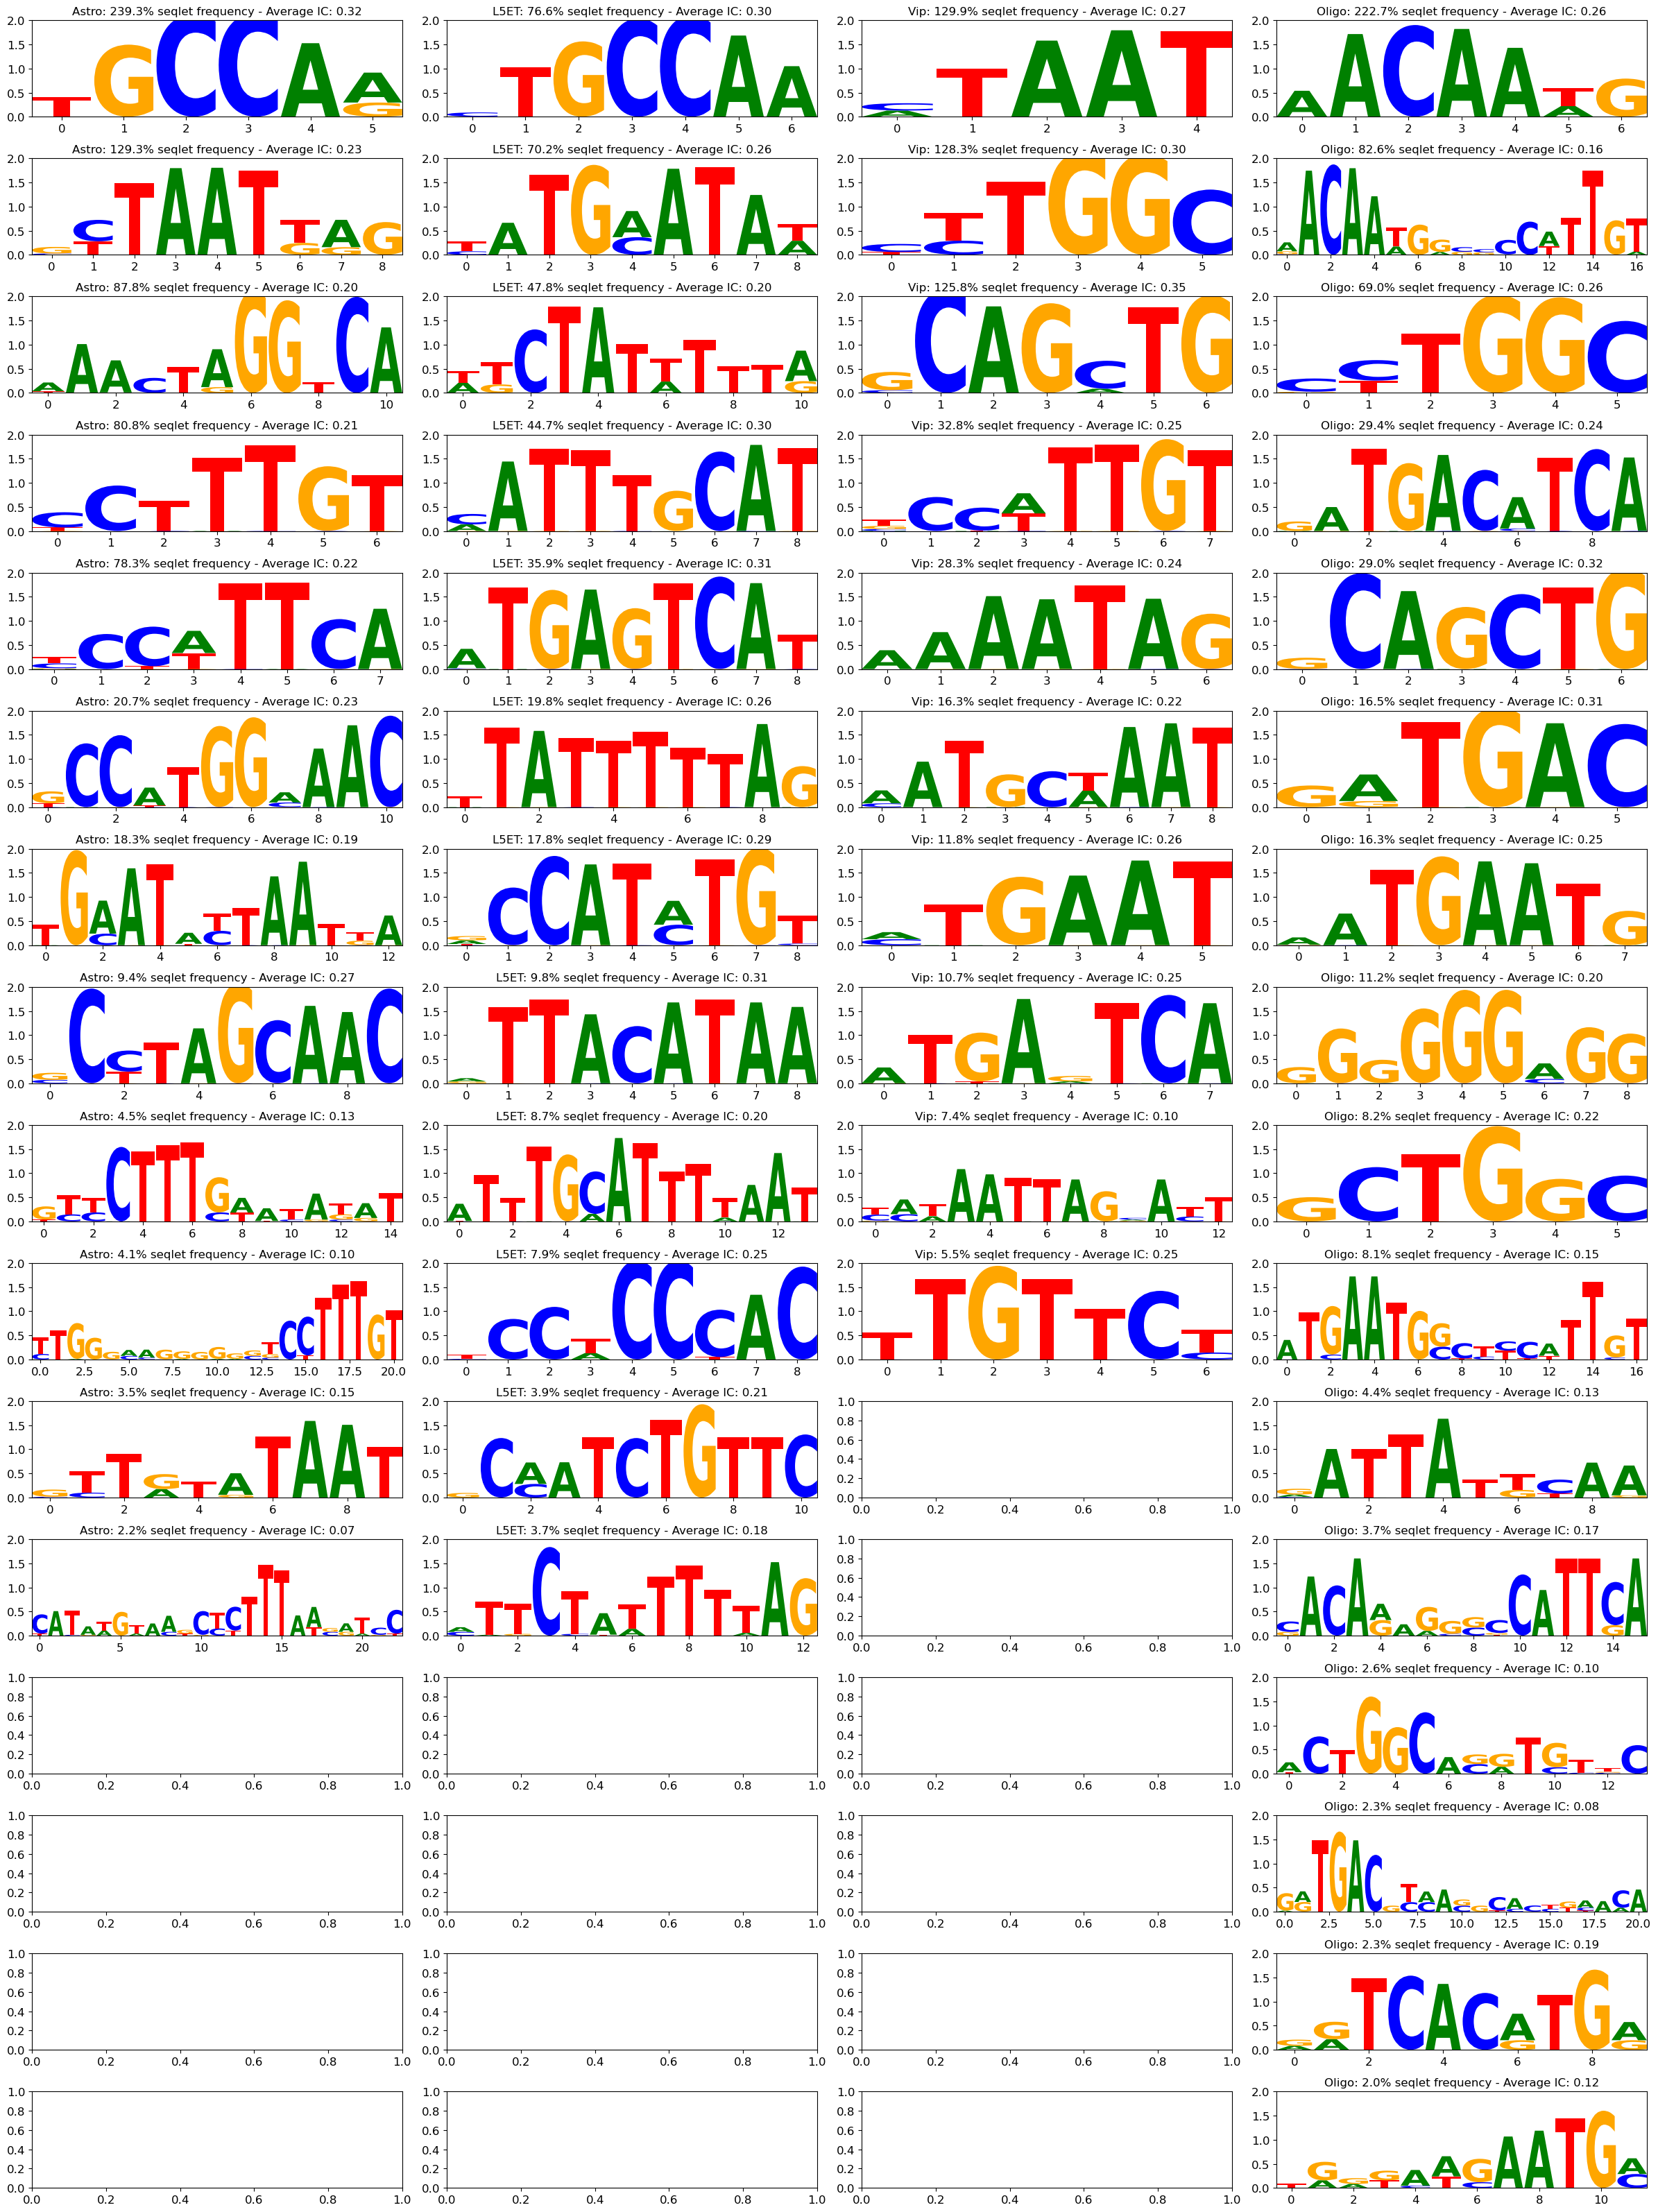

In [76]:
%matplotlib inline
crested.pl.patterns.modisco_results(classes=['Astro','L5ET','Vip','Oligo'], contribution='positive', contribution_dir='modisco_results4', num_seq=top_k, y_max=0.15, viz='pwm') # You can also visualize in 'pwm' format

### Matching patterns across cell types

Since we have calculated per cell type the patterns independently of each other, we do not know quantitavely how and if they overlap.
It can be interesting to get an overview of which patterns are found across multiple cell types, how important they are, and if there are unique patterns only found in a small selection of classes.
Therefore, we have made a pattern clustering algorithm, which start from the results of tfmodisco-lite, and return a pattern matrix, which contains the importance of the clustered patterns per cell type, and a pattern dictionary, describing all clustered patterns.

In [9]:
# First we obtain the resulting modisco files per class
matched_files = crested.tl.match_h5_files_to_classes(contribution_dir='modisco_results4', classes=list(adata.obs_names))

In [209]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
all_patterns = crested.tl.process_patterns(
    matched_files,
    sim_threshold=3.5, # The similarity threshold used for matching patterns. We take the -log10(pval), pval obtained through TOMTOM matching from tangermeme
    trim_ic_threshold=0.1, # Information content (IC) threshold on which to trim patterns
    discard_ic_threshold=0.2, # IC threshold used for discarding single instance patterns
    verbose=True # Useful for doing sanity checks on matching patterns
) 
pattern_matrix = crested.tl.create_pattern_matrix(classes=list(adata.obs_names), all_patterns=all_patterns, normalize=True)
pattern_matrix.shape

Reading file modisco_results4/Astro_modisco_results.h5
Match between Astro_pos_patterns_9 and Astro_pos_patterns_8 with similarity score 4.786168838167354
Reading file modisco_results4/Endo_modisco_results.h5
Match between Endo_neg_patterns_4 and Astro_neg_patterns_1 with similarity score 5.137184669031875
Match between Endo_neg_patterns_20 and Endo_neg_patterns_15 with similarity score 4.017644243881689
Match between Endo_neg_patterns_26 and Endo_neg_patterns_3 with similarity score 4.200937019944412
Match between Endo_neg_patterns_27 and Endo_neg_patterns_20 with similarity score 4.721001880903637
Match between Endo_pos_patterns_0 and Endo_neg_patterns_28 with similarity score 4.873348370010543
Match between Endo_pos_patterns_1 and Astro_pos_patterns_0 with similarity score 5.270968075152102
Match between Endo_pos_patterns_6 and Astro_pos_patterns_8 with similarity score 4.1948062832792905
Match between Endo_pos_patterns_7 and Endo_pos_patterns_1 with similarity score 4.5306096433926

(19, 119)

Now we can plot a clustermap of cell types/classes and patterns, where the classes are clustered purely on pattern importance.

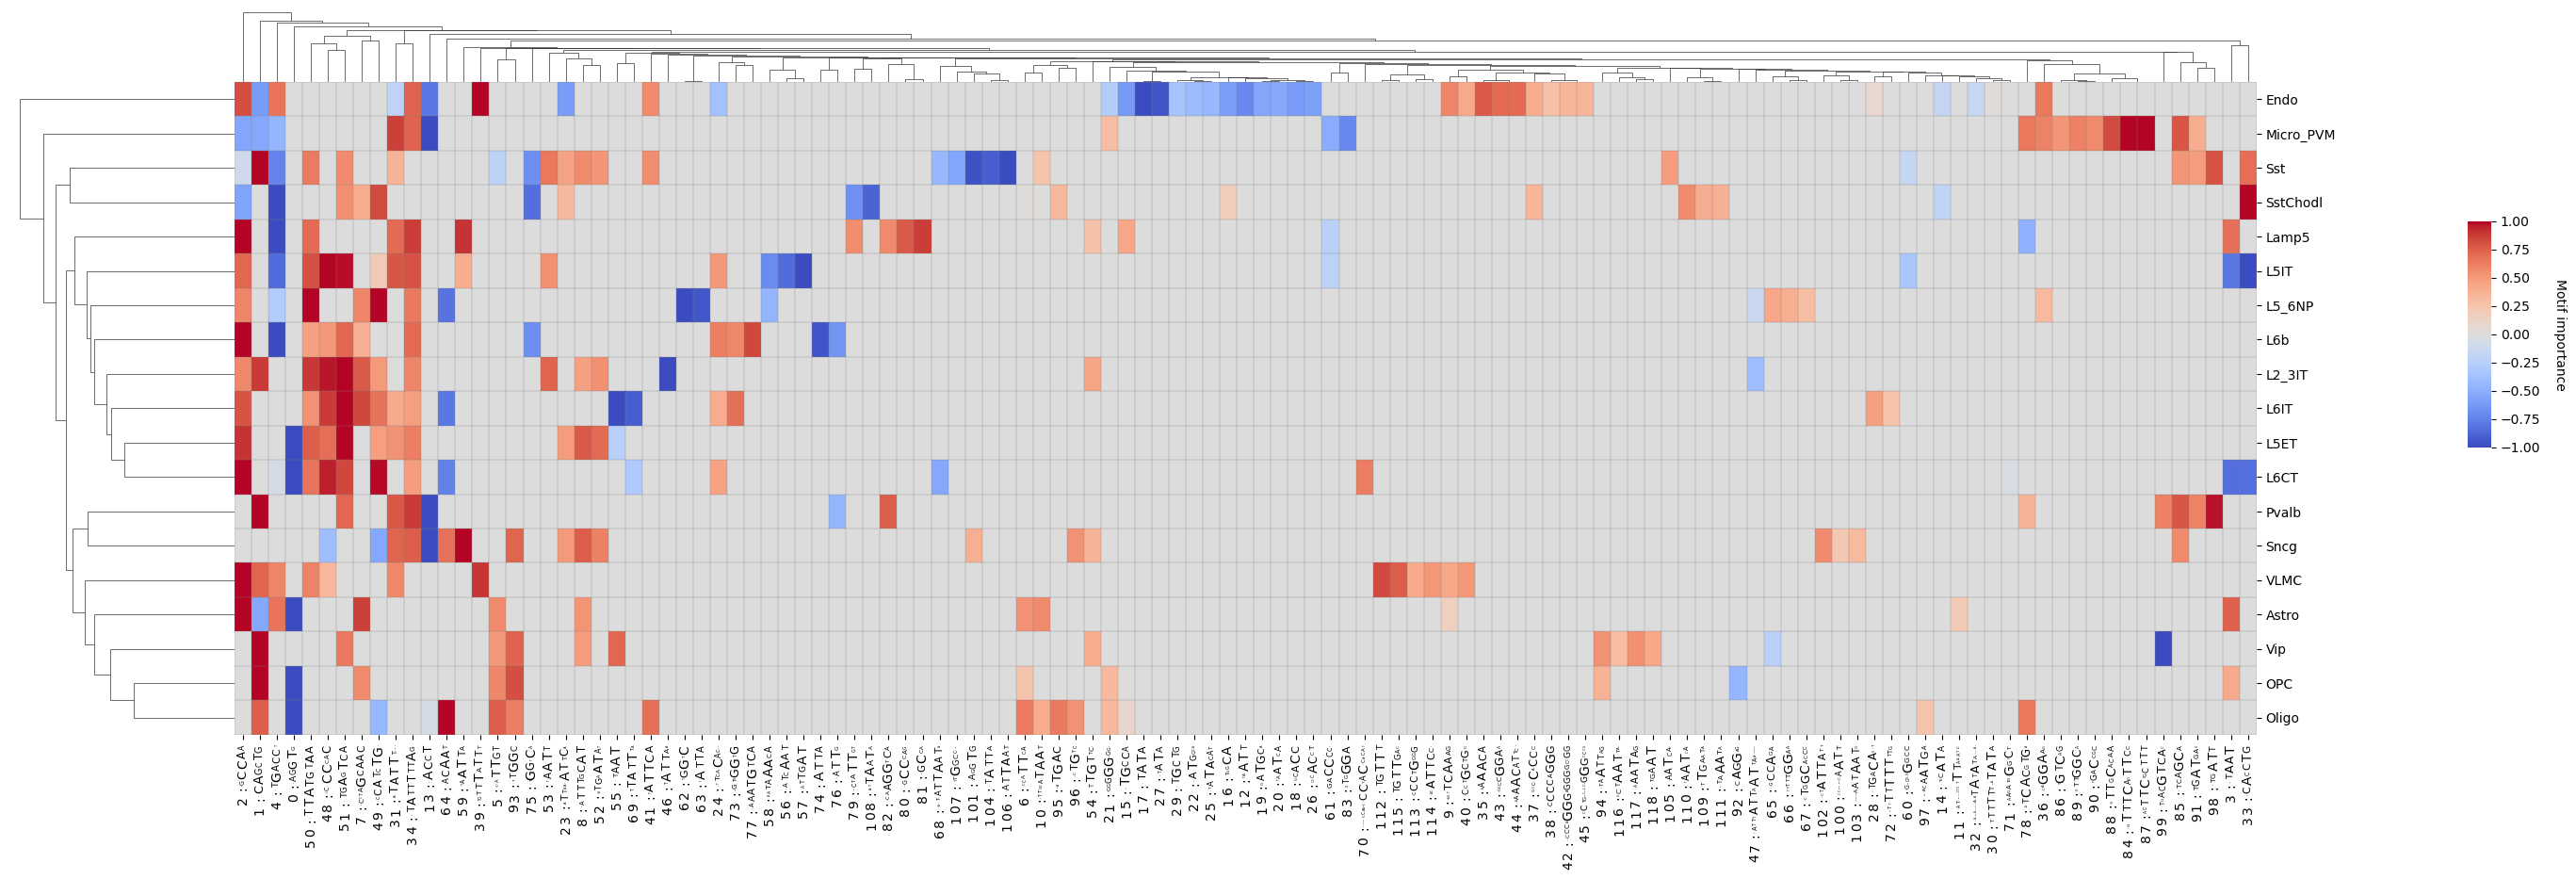

In [229]:
pat_seqs = crested.tl.generate_nucleotide_sequences(all_patterns)
crested.pl.patterns.create_clustermap(pattern_matrix, list(adata.obs_names), figsize=(25,8), pat_seqs=pat_seqs, grid=True)

We can also subset to classes we are interested in and want to compare in more detail.

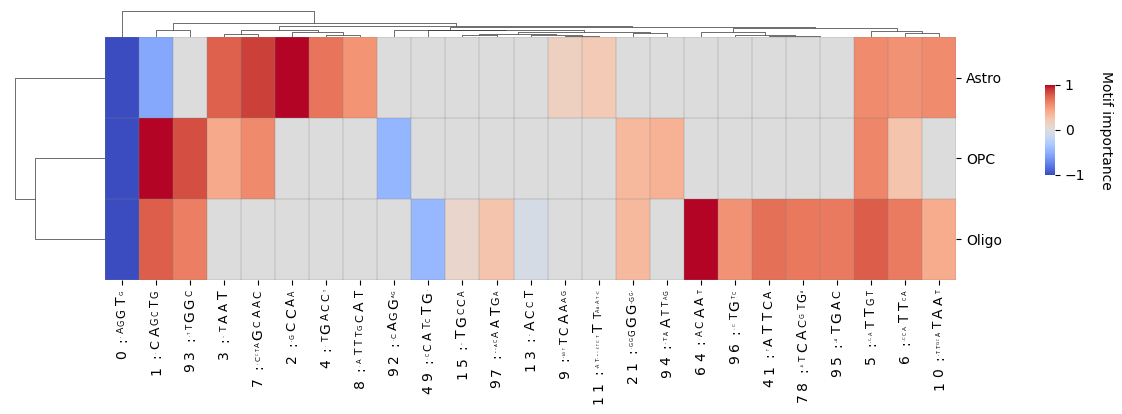

In [231]:
%matplotlib inline
pat_seqs = crested.tl.generate_nucleotide_sequences(all_patterns)
crested.pl.patterns.create_clustermap(pattern_matrix, classes=list(adata.obs_names), subset=['Astro','OPC', 'Oligo'], figsize=(10,3), pat_seqs=pat_seqs, grid=True, dy=0.0025)

#### Additional pattern insights

It is always interesting to investigate specific patterns show in the clustermap above. Here there are some example function on how to do that.

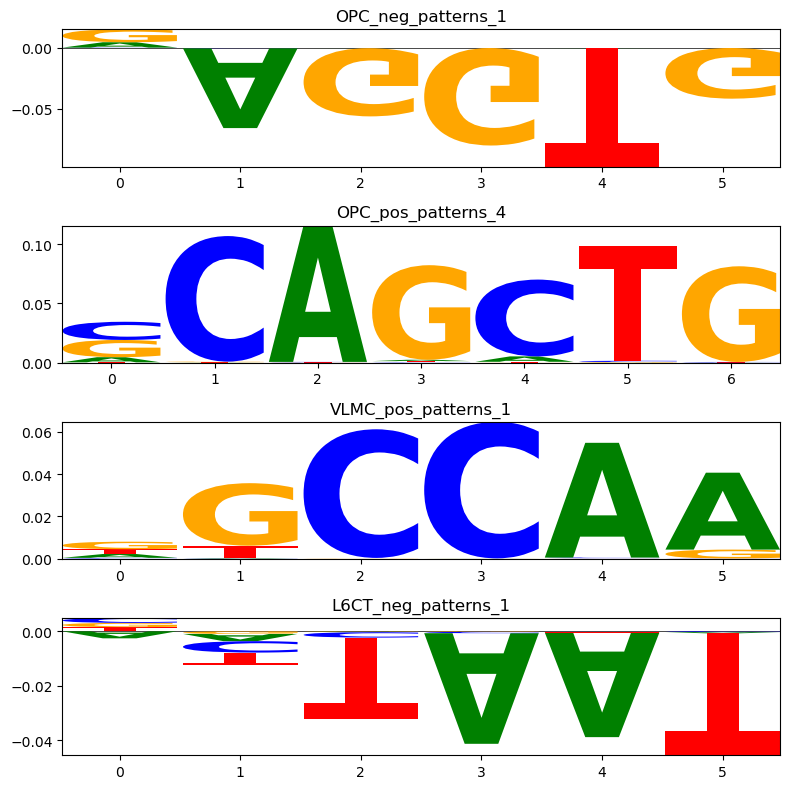

In [232]:
from crested.pl.patterns import plot_patterns, plot_pattern_instances

pattern_indices = [0,1,2,3]
plot_patterns(all_patterns, pattern_indices) # The pattern that is show is the most representative pattern of the cluster with the highest average IC

We can also do a check of pattern similarity

Pattern similarity is 2.8501930453468804


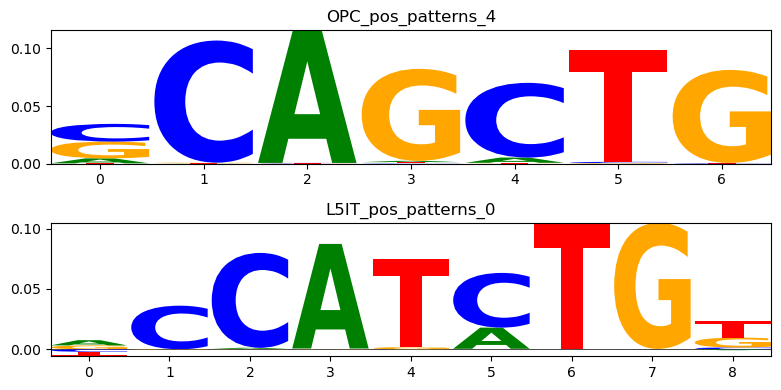

In [233]:
from crested.tl import pattern_similarity
idx1=1
idx2=49
sim = pattern_similarity(all_patterns,idx1,idx2)
print('Pattern similarity is ' + str(sim))
plot_patterns(all_patterns, [idx1, idx2])

And plot all the instances of patterns in the same cluster.

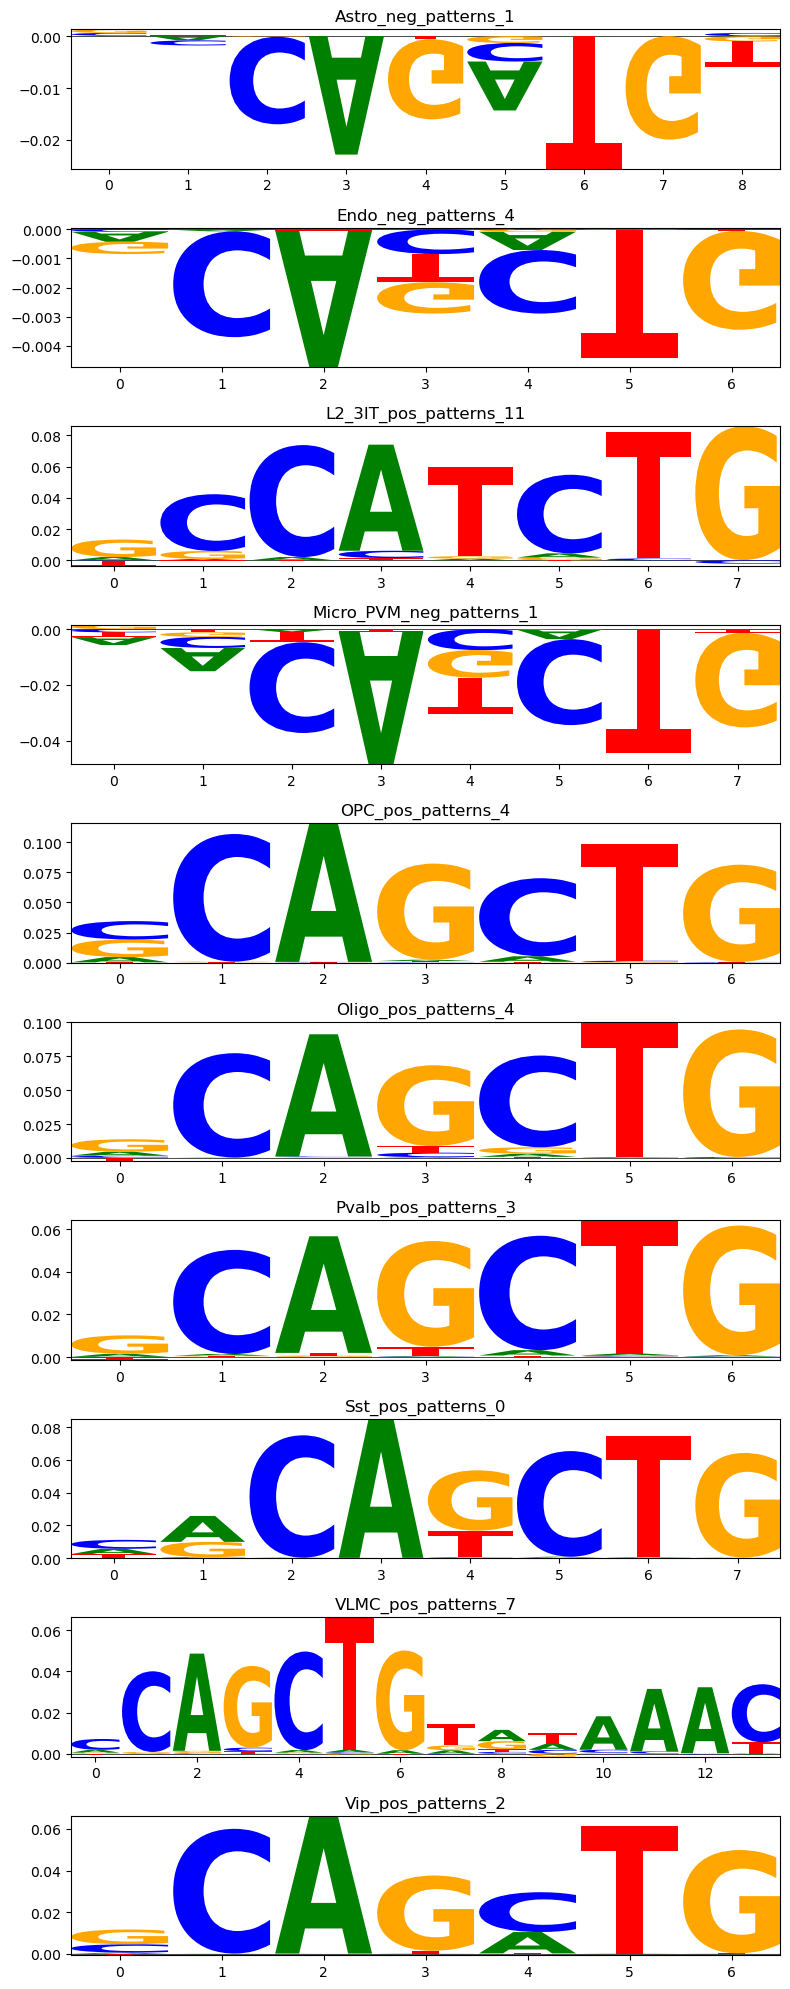

In [212]:
plot_pattern_instances(all_patterns,1)

If you want to find out in which pattern cluster a certain pattern is from your modisco results, you can call the find_pattern function.

Pattern index is 48


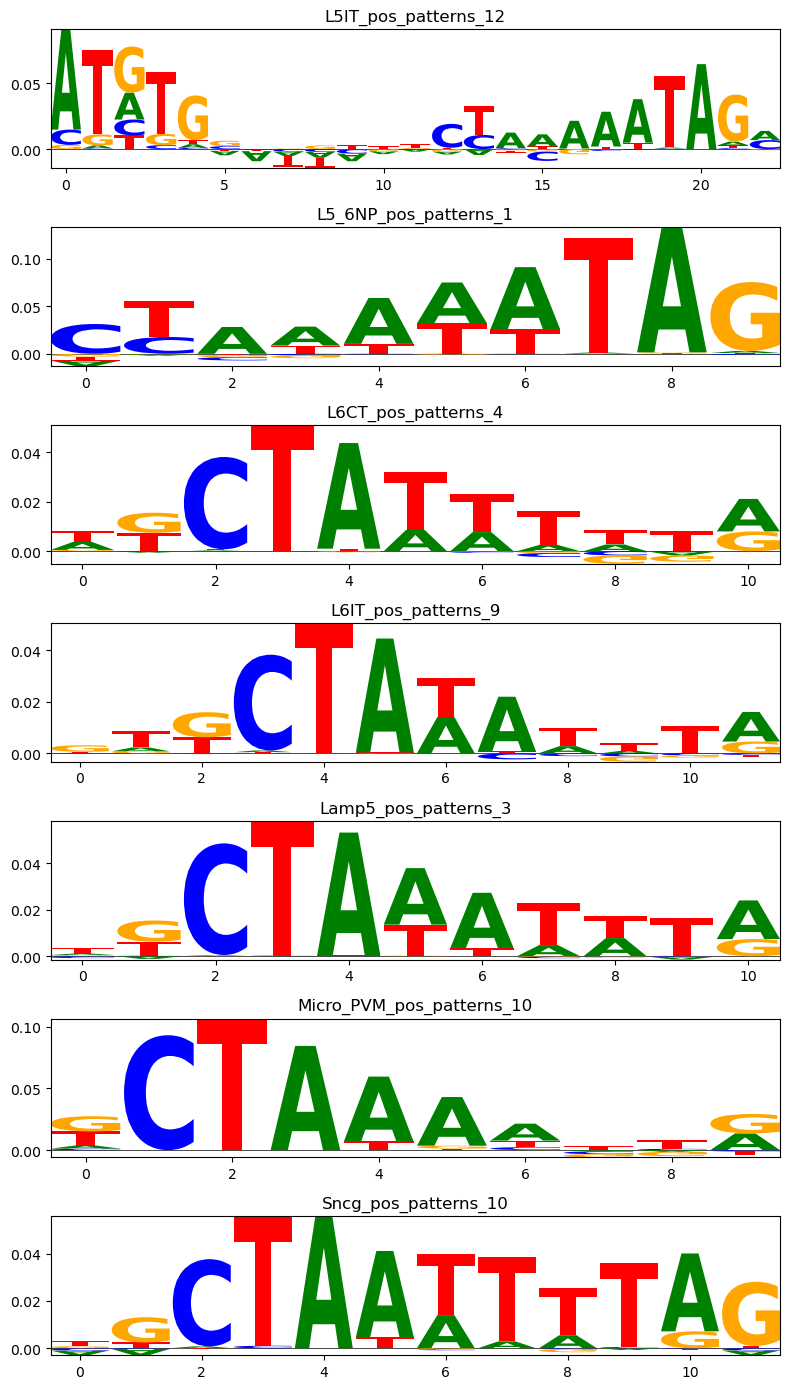

In [159]:
from crested.tl._tfmodisco import find_pattern
idx = find_pattern('L6CT_pos_patterns_4', all_patterns)
if idx is not None:
    print('Pattern index is '+str(idx))
    plot_pattern_instances(all_patterns,idx, class_representative=True)

Finally we can also plot the similarity between all patterns.

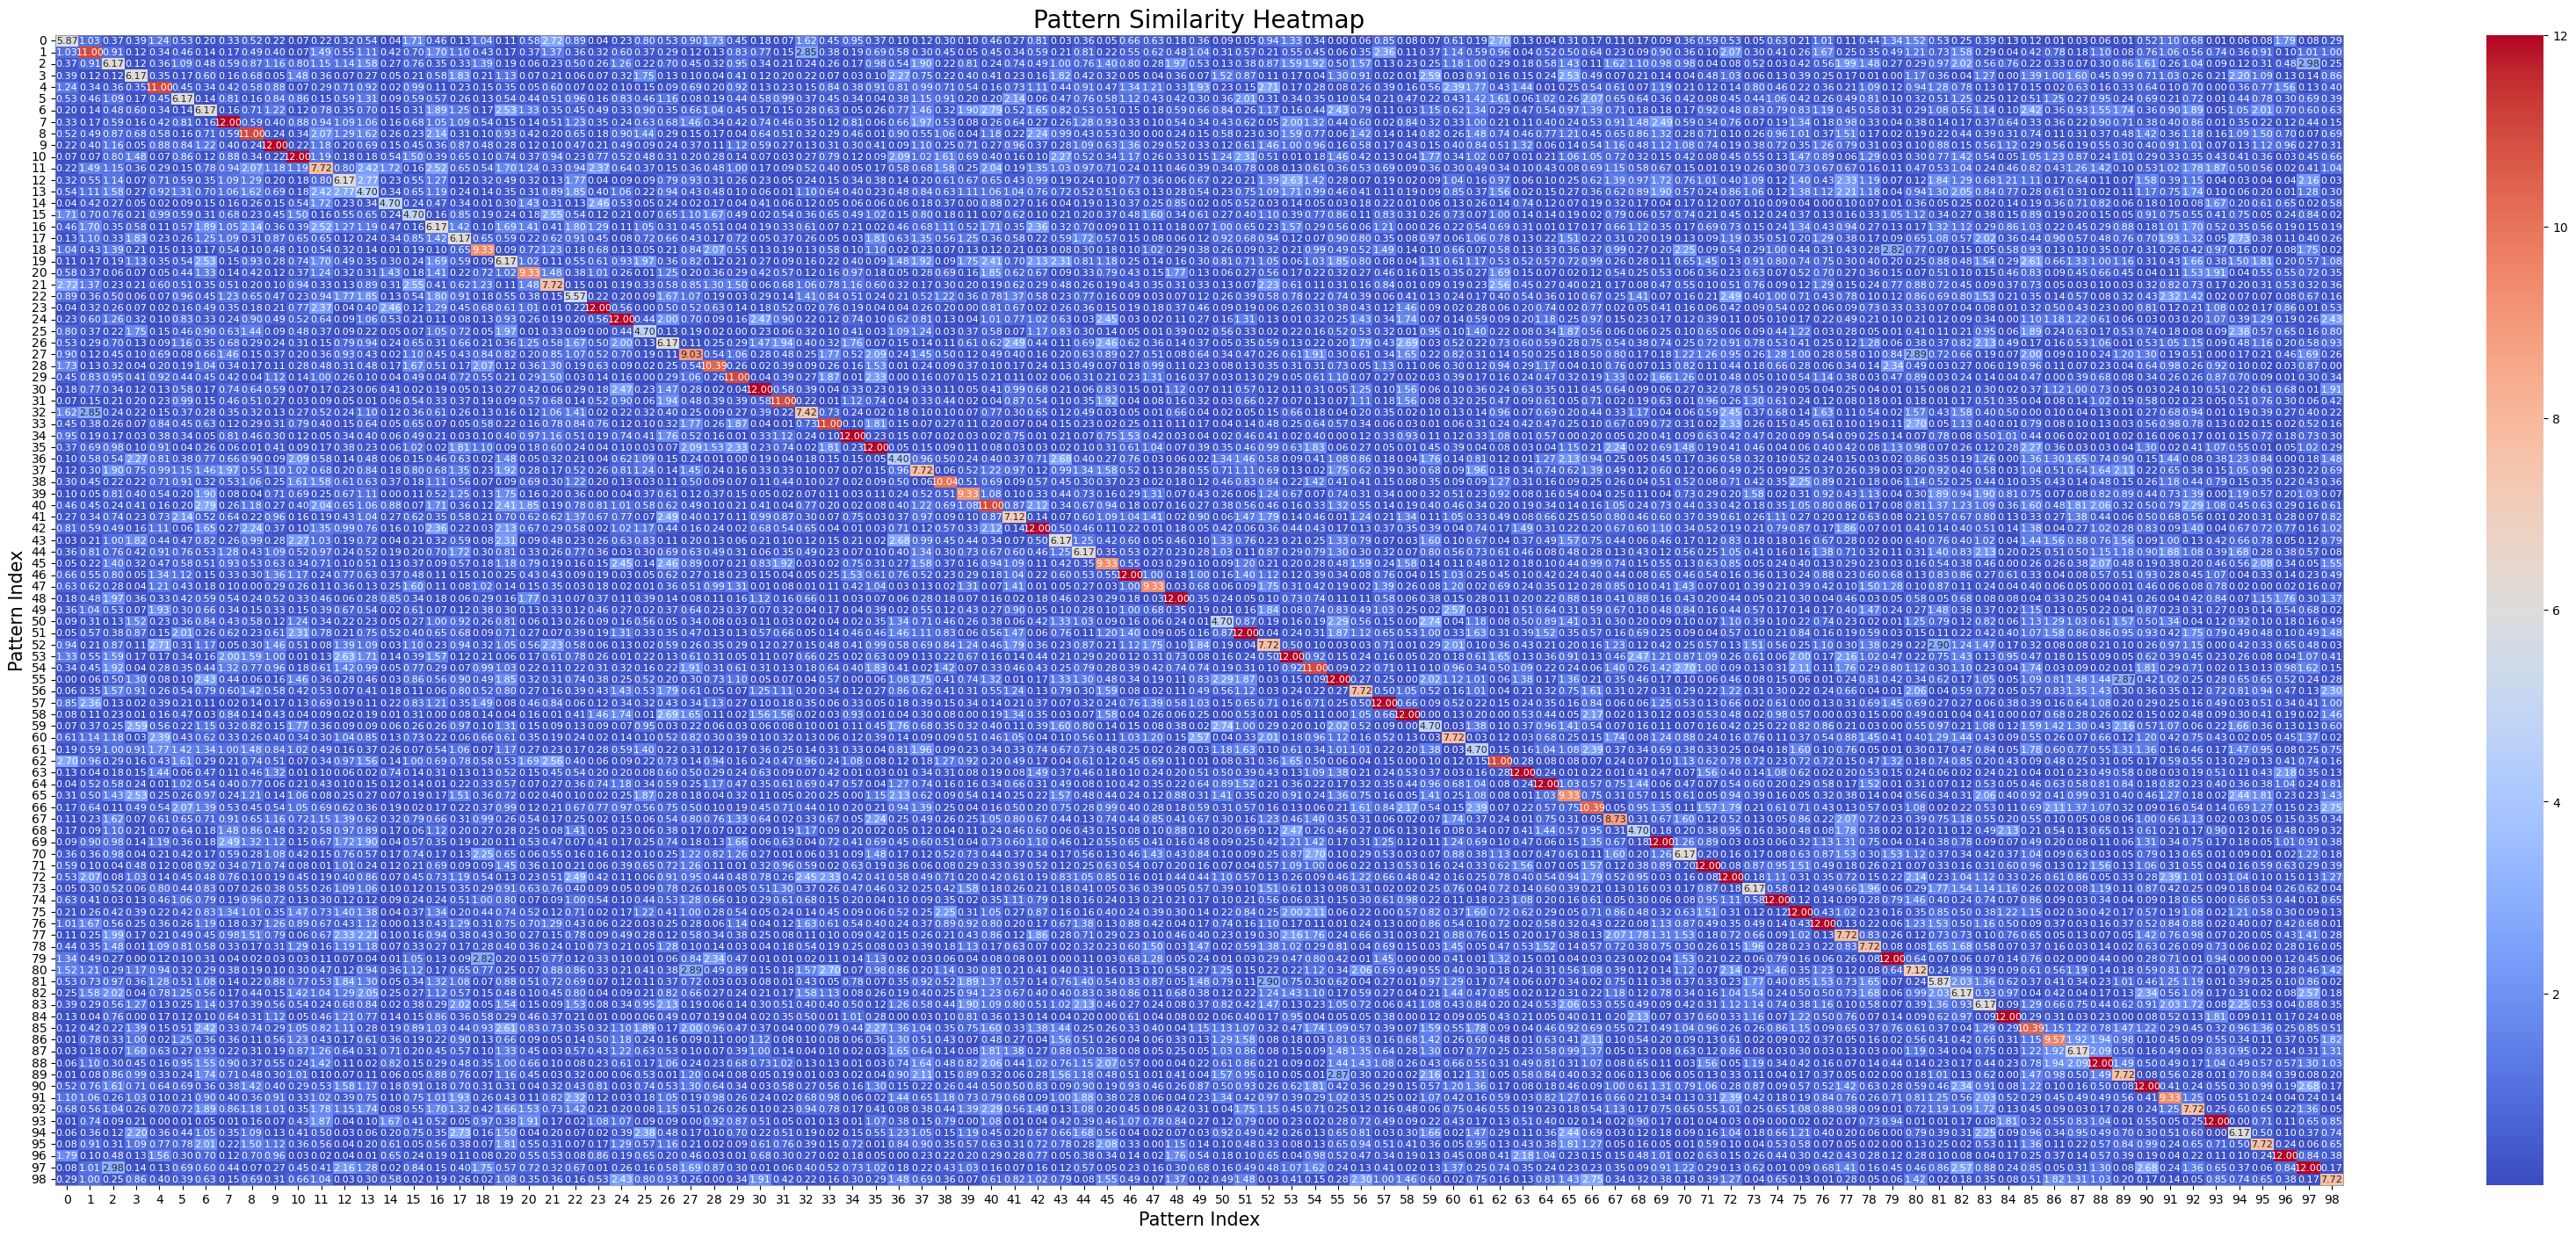

In [165]:
from crested.tl import calculate_similarity_matrix
from crested.pl.patterns import plot_similarity_heatmap
sim_matrix, indices = calculate_similarity_matrix(all_patterns)
plot_similarity_heatmap(sim_matrix, indices, fig_size=(42,17))

### Matching patterns to TF candidates from scRNA-seq data [Optional]

To understand the actual transcription factor (TF) candidates binding to the characteristic patterns/potential binding sites per cell type, we can propose potential candidates through scRNA-seq data and a TF-motif collection file.

**This analysis requires that you ran tfmodisco-lite with the report function such that each pattern has potential MEME database hits.**
The names in the motif database should match those in the TF-motif collection file.

#### Load scRNA-seq data

In [94]:
file_path='/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/Mouse_rna.h5ad' #Locate h5 file containing scRNAseq data
cell_type_column= 'subclass_Bakken_2022'
mean_expression_df = crested.tl.calculate_mean_expression_per_cell_type(file_path, cell_type_column)

/data/projects/c04/cbd-saerts/nkemp/software/CREsted/src/crested/tl/_tfmodisco.py:1121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expression_per_cell_type: pd.DataFrame = gene_expression_df.groupby(cell_metadata[cell_type_column]).mean()


In [95]:
mean_expression_df

Xkr4    Gm1992   Gm19938   Gm37381       Rp1  \
subclass_Bakken_2022                                                      
Astro                  2.065016  0.002408  0.005160  0.000000  0.001032   
Endo                   3.543175  0.008357  0.013928  0.005571  0.030641   
L2/3 IT                4.787437  0.173733  0.172163  0.000857  0.005139   
L5 ET                  2.552023  0.080925  0.112717  0.000000  0.014451   
L5 IT                  7.331720  0.236472  0.242081  0.000220  0.004949   
L5/6 NP               10.830137  0.241096  0.261644  0.000000  0.004110   
L6 CT                 11.685929  0.307494  0.334508  0.000000  0.004698   
L6 IT                  8.851890  0.267620  0.266599  0.000000  0.003064   
L6b                   12.191126  0.372014  0.378840  0.000000  0.006826   
Lamp5                 15.744548  0.353063  0.412253  0.000000  0.005192   
Micro-PVM              3.591667  0.004861  0.000694  0.000694  0.000000   
OPC                    4.641860  0.046512  0.069767  0.000000  0.000000   
Oligo                  5.538625  0.036980  0.047435  0.000000  0.001162   
Pvalb                 18.290524  0.482544  0.540524  0.000623  0.019950   
Sncg                   8.017094  0.222222  0.316239  0.000000  0.000000   
Sst                   21.625330  0.508355  0.578716  0.000000  0.006157   
Sst Chodl             20.053572  0.642857  0.428571  0.000000  0.000000   
VLMC                   2.623077  0.001923  0.001923  0.003846  0.051923   
Vip                   10.467456  0.279290  0.257988  0.000000  0.002367   

                         Sox17    Mrpl15    Lypla1     Tcea1     Rgs20  ...  \
subclass_Bakken_2022                                                    ...   
Astro                 0.000688  0.051944  0.231854  0.255590  5.739250  ...   
Endo                  0.242340  0.030641  0.186630  0.286908  0.286908  ...   
L2/3 IT               0.000000  0.124054  0.194718  0.380443  1.034119  ...   
L5 ET                 0.000000  0.132948  0.161850  0.297688  0.343931  ...   
L5 IT                 0.000000  0.096238  0.185658  0.354597  0.436538  ...   
L5/6 NP               0.000000  0.084932  0.110959  0.379452  0.083562  ...   
L6 CT                 0.000000  0.114635  0.180879  0.398403  0.722340  ...   
L6 IT                 0.000000  0.091931  0.146067  0.371808  0.432074  ...   
L6b                   0.000000  0.122867  0.201365  0.426621  1.911263  ...   
Lamp5                 0.000000  0.102804  0.127726  0.414330  0.063344  ...   
Micro-PVM             0.000000  0.039583  0.136111  0.232639  0.277431  ...   
OPC                   0.000000  0.083721  0.176744  0.311628  1.209302  ...   
Oligo                 0.000000  0.040465  0.129332  0.249177  0.124685  ...   
Pvalb                 0.001247  0.120948  0.289900  0.474439  0.115337  ...   
Sncg                  0.000000  0.119658  0.179487  0.461538  0.324786  ...   
Sst                   0.000000  0.093228  0.204925  0.401935  0.294635  ...   
Sst Chodl             0.000000  0.071429  0.178571  0.535714  0.089286  ...   
VLMC                  0.005769  0.076923  0.230769  0.426923  0.296154  ...   
Vip                   0.000000  0.079290  0.140828  0.323077  0.125444  ...   

                      AC132444.5     Csprs   Gm12406   Gm6313   Gm45121  \
subclass_Bakken_2022                                                      
Astro                    0.00000  0.000000  0.001032  0.00000  0.000000   
Endo                     0.00000  0.000000  0.000000  0.00000  0.000000   
L2/3 IT                  0.00000  0.000000  0.000286  0.00000  0.000286   
L5 ET                    0.00000  0.000000  0.000000  0.00000  0.000000   
L5 IT                    0.00022  0.000000  0.000000  0.00011  0.000110   
L5/6 NP                  0.00000  0.000000  0.000000  0.00000  0.000000   
L6 CT                    0.00000  0.000235  0.000000  0.00000  0.000000   
L6 IT                    0.00000  0.000000  0.000000  0.00000  0.000000   
L6b                      0.00000  0.00000

#### Generating pattern to database motif dictionary

In [96]:
import numpy as np
classes=np.array(adata.obs_names)
contribution_dir='modisco_results4'
html_paths = crested.tl.generate_html_paths(all_patterns, classes, contribution_dir)

pattern_match_dict = crested.tl.find_pattern_matches(all_patterns, html_paths, q_val_thr=0.1) #q_val threshold to only select significant matches
print(pattern_match_dict)

{'1': {'matches': ['transfac_pro__M04806', 'transfac_public__M00184', 'hocomoco__HTF4_MOUSE.H11MO.0.A']}, '2': {'matches': ['homer__NNTGTTTATTTTGGCA_NF1_FOXA1', 'tfdimers__MD00139', 'transfac_pro__M03554']}, '4': {'matches': ['jaspar__MA0072.1', 'transfac_pro__M07306', 'homer__AAYTAGGTCA_RORgt']}, '7': {'matches': ['homer__GGTTGCCATGGCAA_X-box', 'hocomoco__RFX2_MOUSE.H11MO.0.A', 'transfac_pro__M02045']}, '8': {'matches': ['jaspar__MA0789.1', 'stark__VATTWGCAT', 'taipale__POU2F3_DBD_TATGCWAAT']}, '9': {'matches': ['taipale__RFX3_DBD_SGTTGCYARGCAACS', 'swissregulon__mm__Rfx2', 'taipale_cyt_meth__RFX3_NGTTGCCWAGCAACN_eDBD_meth_repr']}, '10': {'matches': ['homer__ACATCAAAGG_Tcf3', 'homer__CCTTTGATST_LEF1', 'cisbp__M00200']}, '13': {'matches': ['taipale_tf_pairs__PAX3_GTCACGCNNMATTAN_HT', 'taipale_tf_pairs__TEAD4_DLX3_RCATTCCNNNYAATTA_CAP', 'taipale_tf_pairs__ETV5_DLX2_RSCGGAANNNNNYAATTA_CAP']}, '21': {'matches': ['cisbp__M01247', 'cisbp__M02099', 'taipale_tf_pairs__PBX4_HOXA10_YNNRTAAATCAA

#### Loading TF-motif database

In [97]:
motif_to_tf_df = crested.tl.read_motif_to_tf_file('/data/projects/c04/cbd-saerts/nkemp/tools/Motif_collection.tsv')
motif_to_tf_df

logo  \
0                                <img src="https://motifcollections.aertslab.org/v10/logos/bergman__Adf1.png" height="52" alt="bergman__Adf1"></img>   
1                                <img src="https://motifcollections.aertslab.org/v10/logos/bergman__Aef1.png" height="52" alt="bergman__Aef1"></img>   
2                                    <img src="https://motifcollections.aertslab.org/v10/logos/bergman__ap.png" height="52" alt="bergman__ap"></img>   
3                        <img src="https://motifcollections.aertslab.org/v10/logos/elemento__ACCTTCA.png" height="52" alt="elemento__ACCTTCA"></img>   
4                                  <img src="https://motifcollections.aertslab.org/v10/logos/bergman__bcd.png" height="52" alt="bergman__bcd"></img>   
...                                                                                                                                              ...   
22471                    <img src="https://motifcollections.aertslab.org/v10/logos/elemento__CAAGGAG.png" height="52" alt="elemento__CAAGGAG"></img>   
22472                    <img src="https://motifcollections.aertslab.org/v10/logos/elemento__TCCTTGC.png" height="52" alt="elemento__TCCTTGC"></img>   
22473      <img src="https://motifcollections.aertslab.org/v10/logos/swissregulon__hs__ZNF274.png" height="52" alt="swissregulon__hs__ZNF274"></img>   
22474  <img src="https://motifcollections.aertslab.org/v10/logos/swissregulon__sacCer__THI2.png" height="52" alt="swissregulon__sacCer__THI2"></img>   
22475                      <img src="https://motifcollections.aertslab.org/v10/logos/jaspar__MA0407.1.png" height="52" alt="jaspar__MA0407.1"></img>   

                       Motif_name  Cluster Human_Direct_annot  \
0                   bergman__Adf1      NaN                NaN   
1                   bergman__Aef1      NaN                NaN   
2                     bergman__ap      NaN                NaN   
3               elemento__ACCTTCA      NaN                NaN   
4                    bergman__bcd      NaN                NaN   
...                           ...      ...                ...   
22471           elemento__CAAGGAG     98.3                NaN   
22472           elemento__TCCTTGC     98.3                NaN   
22473    swissregulon__hs__ZNF274     99.1             ZNF274   
22474  swissregulon__sacCer__THI2     99.2                NaN   
22475            jaspar__MA0407.1     99.2                NaN   

      Human_Orthology_annot Mouse_Direct_annot Mouse_Orthology_annot  \
0                       NaN                NaN                   NaN   
1                       NaN                NaN                   NaN   
2                       NaN                NaN                   NaN   
3                       NaN                NaN                   NaN   
4                       NaN                NaN                   NaN   
...                     ...                ...                   ...   
22471                   NaN                NaN                   NaN   
22472                   NaN                NaN                   NaN   
22473                   NaN                NaN        Zfp369, Zfp110   
22474                   NaN                NaN                   NaN   
22475                   NaN                NaN                   NaN   

      Fly_Direct_annot Fly_Orthology_annot Cluster_Human_Direct_annot  \
0                 Adf1                 NaN                        NaN   
1                 Aef1                 NaN                        NaN   
2                   ap                 NaN                        NaN   
3                  NaN                 NaN                        NaN   
4                  bcd                 NaN                        NaN   
...                ...                 ...                        ...   
22471              NaN                 NaN                        NaN   
22472              NaN                 NaN                        NaN   
22473           

#### Matching patterns to TF candidates

We calculate a pattern-tf by cell type matrix which contains the imporatance of each pattern linked to a TF per cell type.

In [98]:
cols = ['Mouse_Direct_annot', 'Mouse_Orthology_annot', 'Cluster_Mouse_Direct_annot', 'Cluster_Mouse_Orthology_annot']
pattern_tf_dict, all_tfs = crested.tl.create_pattern_tf_dict(pattern_match_dict, motif_to_tf_df, all_patterns, cols)
tf_ct_matrix, tf_pattern_annots = crested.tl.create_tf_ct_matrix(pattern_tf_dict, all_patterns, mean_expression_df, classes, log_transform=True, normalize=True, min_tf_gex=0.3)

Total columns before filtering: 805
Total columns after filtering: 161
Total columns removed: 644


Finally, we can plot a clustermap of potential pattern-TF matches, and their importance per cell type.

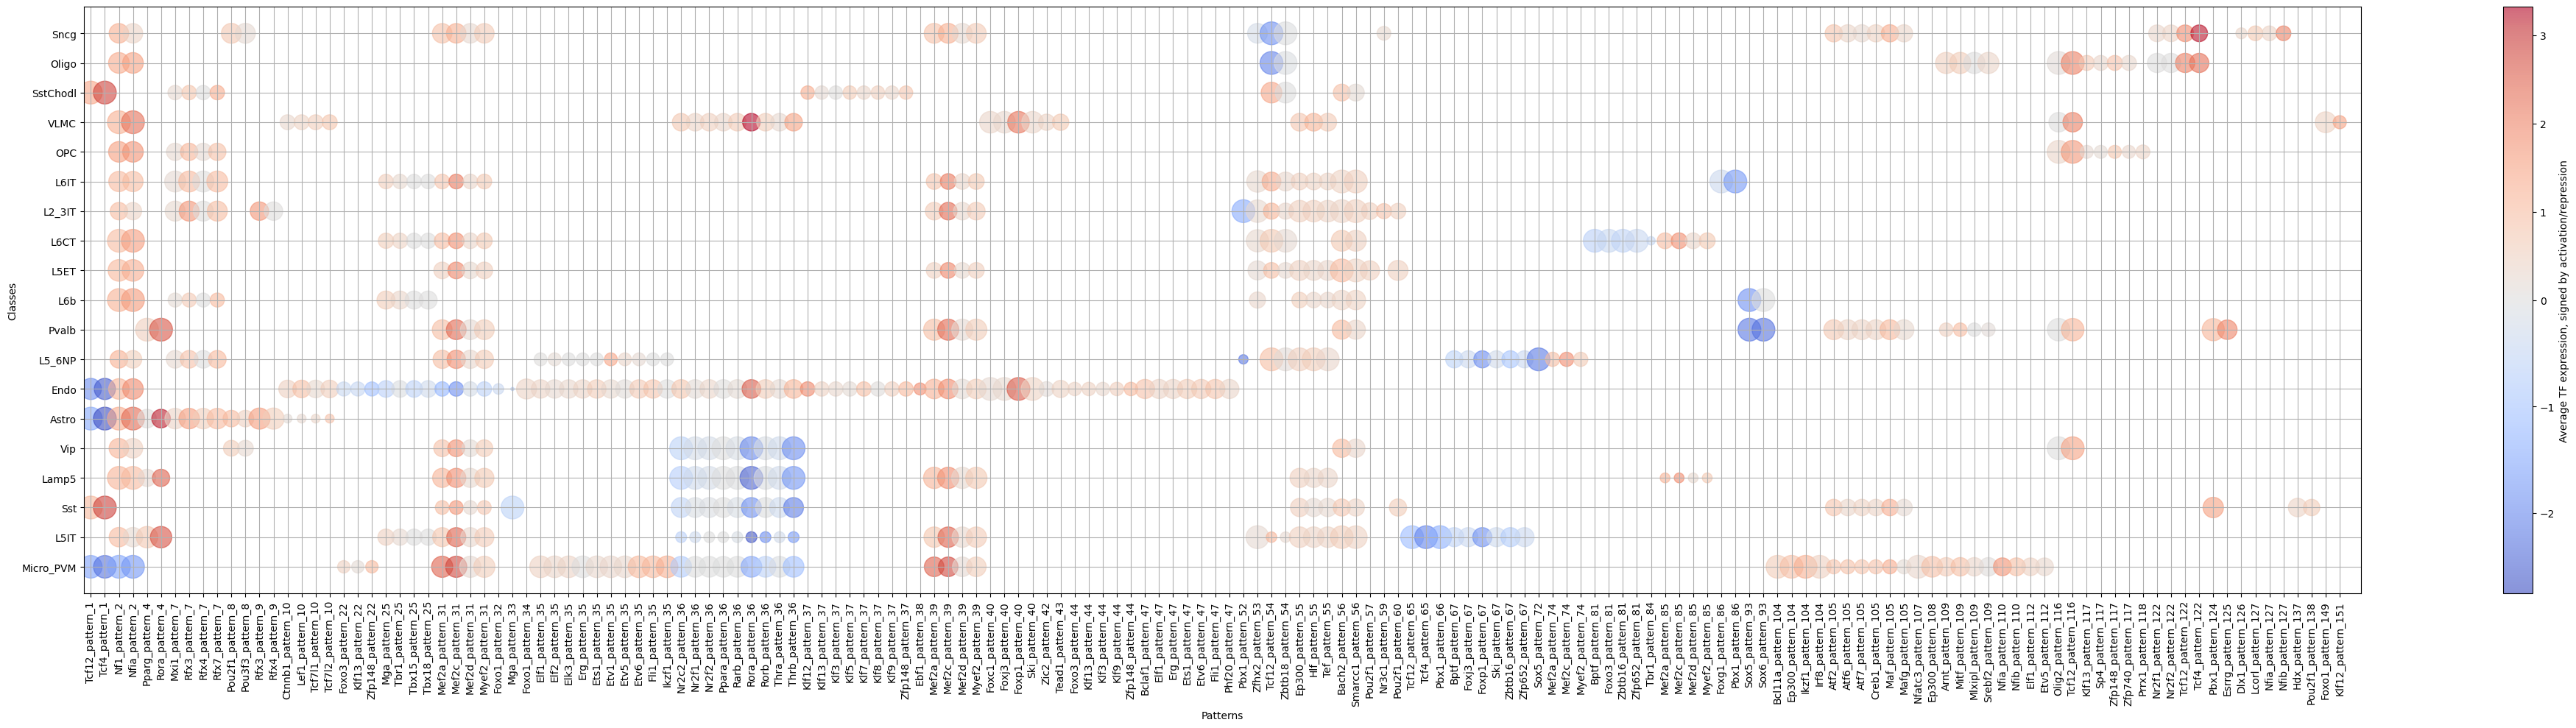

In [99]:
crested.pl.patterns.plot_clustermap_tf_motif(tf_ct_matrix, cluster_on_dim='gex', class_labels=classes, pattern_labels=tf_pattern_annots, color_idx='gex', size_idx='contrib')